In [1]:
############################# Import Section #################################

## Imports related to PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader

## Generic imports
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from copy import deepcopy
import math
import random

## Dependencies classes and functions
from utils import gridRing
from utils import asMinutes
from utils import timeSince
from utils import getWeights
from utils import save_checkpoint
from utils import getListOfFolders

## Import Model
from DyanOF import OFModel,creatRealDictionary,fista

############################# Import Section #################################

C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_numpy_dataset(model,size_dictionary,keys,device):
    model.eval()
    with torch.no_grad():
        cs = []
        y_train = []
        for key in keys:
            X,y = size_dictionary[key]
            X = X.to(device)
            y = y.to(device)
            
            _,_,c = model.forward(X)
#             c = model.get_c(X)

            cs.append(c.cpu().numpy())
            y_train.extend(y.cpu().ravel().numpy())
    X_train = np.vstack(cs)
    return X_train,y_train

In [3]:
def create_ilkay_dataset(model,size_dictionary,keys,device):
    model.eval()
    with torch.no_grad():
        x_train = []
        y_train = []
        for key in keys:
            X,Y = size_dictionary[key]
            for i in range(X.shape[0]):
                x = X[i].to(device)
                y = Y[i].to(device)
        
#                 embedding = model.encoder_.forward(x.unsqueeze(0)).squeeze(0)
                _,_,embedding = model.forward(x.unsqueeze(0))
                embedding.squeeze(0)

#                 embedding = model.get_c(X)

                x_train.append(embedding.cpu().numpy())
                y_train.extend(y.cpu().ravel().numpy())

    return x_train,y_train

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(1)].permute(1,0,2)
        return x

In [5]:
class encoder(nn.Module):
    def __init__(self,D,embed_dim,latent_dim,dimforward,nhead,encoder_layers=1,device='cuda:0'):
        super(encoder,self).__init__()
        self.D = D
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.device = device
        self.nhead = nhead
        
        self.input_projection = nn.Linear(D,embed_dim)
        
        self.tencoder = nn.ModuleList([nn.TransformerEncoderLayer(d_model=embed_dim,dim_feedforward=dimforward,nhead=nhead,batch_first=True,dropout=.1) for i in range(encoder_layers)])

        self.projection = nn.Linear(embed_dim,latent_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)

        
    def forward(self,x):

        x = self.pos_encoder(self.input_projection(x))
        for encoder in self.tencoder:
            x = torch.tanh(encoder(x))


        latent = self.projection(x)
        
        return latent

In [6]:
class decoder(nn.Module):
    def __init__(self,D,embed_dim,latent_dim,dimforward,nhead,decoder_layers=1,device='cuda:0'):
        super(decoder,self).__init__()
        self.D = D
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.device = device
        self.nhead = nhead
        
        self.output_projection = nn.Linear(latent_dim,embed_dim)
        
        
        self.tdecoder = nn.ModuleList([nn.TransformerEncoderLayer(d_model=embed_dim,nhead=nhead,dim_feedforward=dimforward,batch_first=True,dropout=.1) for i in range(decoder_layers)])

        self.projection = nn.Linear(embed_dim,D)
        self.pos_encoder = PositionalEncoding(embed_dim)

    def forward(self,x):
        x = self.pos_encoder(self.output_projection(x))
        sz = x.shape[1]
#         mask = self.generate_square_subsequent_mask(sz)
        for i,decoder in enumerate(self.tdecoder):
            x = torch.tanh(decoder(x)) #,mask))

        x = self.projection(x)
        
        return x
    
    def generate_square_subsequent_mask(self,sz):
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(self.device)

In [7]:
class TDYANT(nn.Module):
    def __init__(self, 
                 Drr, 
                 Dtheta,
                 N,
                 D,
                 embed_dim,
                 latent_dim,
                 dimforward,
                 nhead,
                 encoder_layers=1,
                 decoder_layers=1,
                 device='cuda:0',
                clamp=2):
        super(TDYANT, self).__init__()
        
        self.rr = nn.Parameter(Drr)
        self.theta = nn.Parameter(Dtheta)
        #self.T = T
        self.device = device
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.nhead = nhead
        self.dimforward = dimforward
        
        self.encoder_ = encoder(D,embed_dim,latent_dim,dimforward,nhead,encoder_layers,device)
        self.decoder_ = decoder(D,embed_dim,latent_dim,dimforward,nhead,decoder_layers,device)
        self.clamp = clamp
        
    def forward(self, x):
        T = x.shape[1]
        
        if self.clamp == 0:
            latent = self.encoder_(x)
        else:
            latent = torch.tanh(self.encoder_(x))*self.clamp #torch.clamp(self.encoder_(x),-2,2)

        dic = creatRealDictionary(T,self.rr,self.theta,self.device)

        sparsecode = fista(dic,latent,0.01,100,self.device)

        y = torch.matmul(dic,sparsecode)

        
        x = self.decoder_(y)

        return x,latent,y
    
    def get_c(self,x):
        T = x.shape[1]

        if self.clamp == 0:
            latent = self.encoder_(x)
        else:
            latent = torch.tanh(self.encoder_(x))*self.clamp #torch.clamp(self.encoder_(x),-2,2)

        dic = creatRealDictionary(T,self.rr,self.theta,self.device)

        ## for UCF Dataset:
        sparsecode = fista(dic,latent,0.1,100,self.device)

        # x is the outer layer , y is the inner layer
        return sparsecode

In [8]:
def create_data_dictionary(df,labels,chunk_size=1,task="classification"):
    size_dictionary = {}
    for i in df.index.unique():
        x = torch.FloatTensor(df.loc[i].values)
#         x = (x - x.mean(0,keepdim=True))/x.std(0,keepdim=True)

            
        if task == "classification":
            y = torch.LongTensor([labels.loc[i].item()])
        else:
            y = torch.FloatTensor([labels.loc[i].item()])
            
        x = torch.chunk(x,chunk_size)
        
        for chunk in x:
            size = chunk.shape[0]
    
            if size_dictionary.get(size) is None:
                size_dictionary[size] = [(chunk,y)]
                
            else:
                size_dictionary[size].append((chunk,y))

    for key in size_dictionary.keys():
        Xs, ys = list(zip(*size_dictionary[key]))
        size_dictionary[key] = (torch.stack(Xs,0),torch.stack(ys,0))
    
    keys = np.array(list(size_dictionary.keys()))[np.argsort([size_dictionary[key][0].shape[0] for key in size_dictionary.keys()])[::-1]]
    return size_dictionary,keys

In [9]:
def train_loop(model,optimizer,criterion,size_dictionary,keys,lam1=1,lam2=1,lam3=1):
    loss_value = []
    loss1_value = []
    loss2_value = []
    norms_value = []
    scheduler.step()
    #for i_batch, sample in enumerate(dataloader):
    predictions = []
    labels = []
    model.train()
    for key in keys:
        Xs,ys = size_dictionary[key]
        train_dl = DataLoader(TensorDataset(Xs,ys),batch_size=BATCH_SIZE,shuffle=True)
        for X,y in train_dl:
            T = X.shape[1]
            X = X.to(device) #cuda()
            y = y.to(device) #cuda()
            data = X

            inputData = Variable(data)
            optimizer.zero_grad()
            x_pred,latent,y_pred = model.forward(inputData)
            

            norms,MSE_LOSS1,MSE_LOSS2,loss = criterion(inputData,x_pred,latent,y_pred,lam1=lam1,lam2=lam2,lam3=lam3)

            loss.backward()
                        
            optimizer.step()
            loss_value.append(loss.data.item())
            loss1_value.append(MSE_LOSS1.data.item())
            loss2_value.append(MSE_LOSS2.data.item())
            norms_value.append(norms.data.item())

#             with torch.no_grad():
#                 predictions.extend(y_pred.argmax(1).cpu().numpy().tolist())
#                 labels.extend(y.ravel().cpu().numpy().tolist())
    
    loss_val = np.mean(np.array(loss_value))
    loss1_val = np.mean(np.array(loss1_value))
    loss2_val = np.mean(np.array(loss2_value))
    norms_val = np.mean(np.array(norms_value))
    return (norms_val,loss1_val,loss2_val,loss_val),predictions,labels 

In [10]:
def evaluation_loop(model,criterion,size_dictionary,keys,lam1=1,lam2=1,lam3=1):
    with torch.no_grad():
        loss_value = []
        loss1_value = []
        loss2_value = []
        norms_value = []
        #for i_batch, sample in enumerate(dataloader):
        predictions = []
        labels = []
        model.eval()
        for key in keys:
            Xs,ys = size_dictionary[key]
            train_dl = DataLoader(TensorDataset(Xs,ys),batch_size=BATCH_SIZE,shuffle=True)
            for X,y in train_dl:
                T = X.shape[1]
                X = X.to(device) #cuda()
                y = y.to(device) #cuda()
                data = X

                inputData = Variable(data)

                x_pred,latent,y_pred = model.forward(inputData)


                norms,MSE_LOSS1,MSE_LOSS2,loss = criterion(inputData,x_pred,latent,y_pred,lam1=lam1,lam2=lam2,lam3=lam3)

                loss_value.append(loss.data.item())
                loss1_value.append(MSE_LOSS1.data.item())
                loss2_value.append(MSE_LOSS2.data.item())
                norms_value.append(norms.data.item())

        loss_val = np.mean(np.array(loss_value))
        loss1_val = np.mean(np.array(loss1_value))
        loss2_val = np.mean(np.array(loss2_value))
        norms_val = np.mean(np.array(norms_value))
        return (norms_val,loss1_val,loss2_val,loss_val),predictions,labels 

In [11]:
def criterion(x,x_pred,y,y_pred,lam1=1,lam2=1,lam3=1):
    """
    lam1 is reconstruction loss
    lam2 is latent reconstruction loss
    lam3 is norm loss
    
    """
    MSE_LOSS_actual = torch.nn.functional.mse_loss(x_pred,x)
    MSE_LOSS_latent = torch.nn.functional.mse_loss(y_pred,y)#
    NORM_LOSS = torch.norm(y,p='fro',dim=1).mean()

    loss = lam1*MSE_LOSS_actual + lam2*MSE_LOSS_latent - lam3*torch.clamp(NORM_LOSS,-1,1)  # if Kitti: loss = loss_mse(output, expectedOut)
  
#     with torch.no_grad():
#         NORM_LOSS = torch.norm(y_pred,p='fro',dim=1).mean()

    return NORM_LOSS,MSE_LOSS_latent,MSE_LOSS_actual,loss

In [12]:
## HyperParameters for the Network
NumOfPoles = 40

N = NumOfPoles*4

dataset_name = "Heartbeat"
## Load saved model 
load_ckpt = False
checkptname = dataset_name
ckpt_file = f"data/{dataset_name}/"+checkptname+str(10)+'.pth' # for Kitti Dataset: 'KittiModel.pth'

In [13]:
with open(f"data/{dataset_name}/{dataset_name}_train_inputs.pickle", "rb") as handle:
    train_df = pickle.load(handle)
    
with open(f"data/{dataset_name}/{dataset_name}_train_labels.pickle", "rb") as handle:
    train_labels = pickle.load(handle) 

with open(f"data/{dataset_name}/{dataset_name}_test_inputs.pickle", "rb") as handle:
    test_df = pickle.load(handle)
    
with open(f"data/{dataset_name}/{dataset_name}_test_labels.pickle", "rb") as handle:
    test_labels = pickle.load(handle)    
    # train_dictionary,train_keys = create_data_dictionary(train_df,train_labels)


In [14]:
# train_df = pd.DataFrame(np.concatenate([np.expand_dims(train_df.loc[i],0) for i in np.unique(train_df.index)],axis=0))
# test_df = pd.DataFrame(np.concatenate([np.expand_dims(test_df.loc[i],0) for i in np.unique(test_df.index)],axis=0))

In [15]:
train_dictionary,train_keys = create_data_dictionary(train_df,train_labels,chunk_size=1,task="classification")
test_dictionary,test_keys = create_data_dictionary(test_df,test_labels,chunk_size=1,task="classification")

In [16]:
D = train_df.shape[1]
N_class = len(np.unique(train_labels.values))

In [17]:
print("Training Data Shape",train_df.index.unique().shape)
print("Testing Data Shape",test_df.index.unique().shape)
print("Training Data Classes",N_class)
print("Training Data Dimension: ",D)
print("Training Sizes: ",train_keys)
print("Testing Sizes: ",test_keys)

Training Data Shape (204,)
Testing Data Shape (205,)
Training Data Classes 2
Training Data Dimension:  61
Training Sizes:  [405]
Testing Sizes:  [405]


In [18]:
## Initializing r, theta
P,Pall = gridRing(N)
Drr = abs(P)
Drr = torch.from_numpy(Drr).float() #.to(device)
Dtheta = np.angle(P)
Dtheta = torch.from_numpy(Dtheta).float() #.to(device)

In [19]:
import time

In [20]:
# MODEL PARAMETERS
embed_dim = 256
latent_dim= 128
dimfeedforward = 1024
nhead=16
D = train_df.shape[1]
clamp = 1
encoder_layers=1
decoder_layers=1
device = torch.device("cuda:0")

# TRAINING PARAMETERS
BATCH_SIZE = 4
LR = 0.001
EPOCH = 300
print_every = 5
saveEvery = 10

In [21]:
## Create the model
model = TDYANT(Drr,
                Dtheta,
                N ,
                D, 
                embed_dim,
                latent_dim,
               dimfeedforward,
               nhead,
                encoder_layers,
                decoder_layers,
                device,
                clamp).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=1e-8)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[150,200], gamma=0.1) # if Kitti: milestones=[100,150]

In [22]:
model.device = "cuda:0"
model = model.cuda()
device = "cuda:0"

In [23]:
start_epoch = 1

## If want to continue training from a checkpoint
if(load_ckpt):
    print("LOADING CHECKPT")
    loadedcheckpoint = torch.load(ckpt_file)
    start_epoch = loadedcheckpoint['epoch']
    model.load_state_dict(loadedcheckpoint['state_dict'])
    optimizer.load_state_dict(loadedcheckpoint['optimizer'])

print("Training from epoch: ", start_epoch)
print('-' * 25)

## Start the Training
for epoch in range(start_epoch, EPOCH+1):
    random.shuffle(train_keys)
    start = time.time()
    (norms,loss1,loss2,loss_train),predictions,labels = train_loop(model,optimizer,criterion,train_dictionary,train_keys,lam1=1,lam2=0.0,lam3=0)
    end = time.time()
    torch.cuda.empty_cache()
    if (epoch)%print_every == 0:
        (norms_v,loss1_v,loss2_v,loss_val),predictions,labels = evaluation_loop(model,criterion,test_dictionary,test_keys,lam1=1,lam2=0,lam3=0)
    torch.cuda.empty_cache()
    print('Epoch: ', epoch)
    print("| train time: %.6f" % (end-start))
    print('| train loss: %.6f' % loss_train)
    print('| train loss LATENT: %.6f' % loss1)
    print('| train loss ACTUAL: %.6f' % loss2)
    print('| LATENT NORM: %.6f' % norms)
    if (epoch)%print_every == 0:
        print('| val loss: %.6f' % loss_val)
        print('| val loss LATENT: %.6f' % loss1_v)
        print('| val loss ACTUAL: %.6f' % loss2_v)
        print('| val LATENT NORM: %.6f' % norms_v)
    print("\n")

#     print("Classification Report:")
#     print(classification_report(labels,predictions,zero_division=1))
    
    if epoch % saveEvery ==0 :
        print("Saving Checkpoint")
        save_checkpoint({'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer' : optimizer.state_dict(),
                        },f"data/{checkptname}/"+checkptname+str(epoch)+'.pth')

Training from epoch:  1
-------------------------


C:\Users\lpott\anaconda3\envs\DYAN\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch:  1
| train time: 38.867151
| train loss: 0.170799
| train loss LATENT: 0.030532
| train loss ACTUAL: 0.170799
| LATENT NORM: 11.060445


Epoch:  2
| train time: 35.360236
| train loss: 0.131881
| train loss LATENT: 0.051723
| train loss ACTUAL: 0.131881
| LATENT NORM: 12.947787


Epoch:  3
| train time: 35.785854
| train loss: 0.114917
| train loss LATENT: 0.036308
| train loss ACTUAL: 0.114917
| LATENT NORM: 13.216068


Epoch:  4
| train time: 35.240444
| train loss: 0.106436
| train loss LATENT: 0.043559
| train loss ACTUAL: 0.106436
| LATENT NORM: 13.547949


Epoch:  5
| train time: 35.842951
| train loss: 0.118765
| train loss LATENT: 0.038833
| train loss ACTUAL: 0.118765
| LATENT NORM: 15.829712
| val loss: 0.142986
| val loss LATENT: 0.070805
| val loss ACTUAL: 0.142986
| val LATENT NORM: 17.483374


Epoch:  6
| train time: 35.524199
| train loss: 0.107853
| train loss LATENT: 0.043881
| train loss ACTUAL: 0.107853
| LATENT NORM: 16.632814


Epoch:  7
| train time: 35.913

KeyboardInterrupt: 

In [ ]:
if(load_ckpt):
    print("LOADING CHECKPT")
    loadedcheckpoint = torch.load(ckpt_file)
    start_epoch = loadedcheckpoint['epoch']
    model.load_state_dict(loadedcheckpoint['state_dict'])
    optimizer.load_state_dict(loadedcheckpoint['optimizer'])

In [ ]:
model = model.to("cuda:0")
model.device = "cuda:0"

In [ ]:
train_keys

In [ ]:
with torch.no_grad():
    model.forward(test_dictionary[T][0][n].unsqueeze(0).cuda())[2].cpu().detach().numpy()

In [ ]:
test_keys

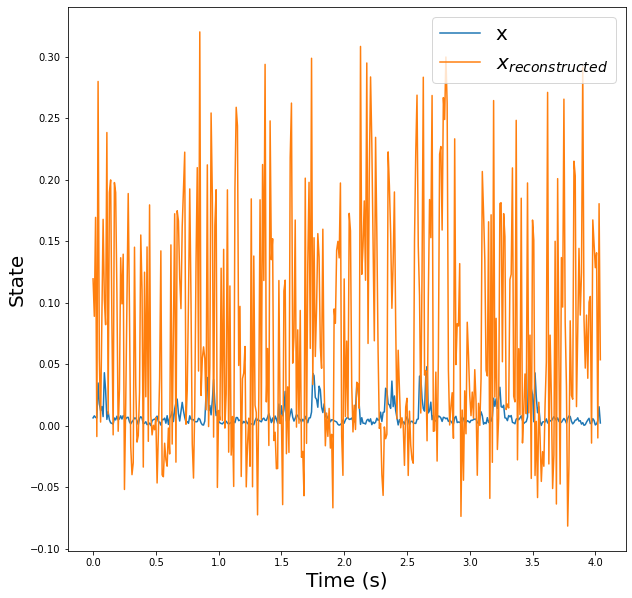

In [24]:
n = 3
i = 1
T = 405
with torch.no_grad():

    
    x_pred = model.forward(test_dictionary[T][0][n].unsqueeze(0).cuda())[0].cpu().detach().numpy()
    plt.figure(figsize=(10,10))
#     for i in range(3):
    plt.plot(np.arange(len(x_pred[0,:,i]))*0.01,test_dictionary[T][0][n,:,i])#,'b-')
    plt.plot(np.arange(len(x_pred[0,:,i]))*0.01,x_pred[0,:,i])#,'r--')
    plt.xlabel("Time (s)",fontsize=20)
    plt.ylabel("State",fontsize=20)
    plt.legend(["x","$x_{reconstructed}$","y","$y_{reconstructed}$","z","$z_{reconstructed}$"],fontsize=20)

In [ ]:
X_train,y_train = create_ilkay_dataset(model,train_dictionary,train_keys,device)
X_test,y_test = create_ilkay_dataset(model,test_dictionary,test_keys,device)

In [ ]:
with open(f"data/{dataset_name}/{dataset_name}_train_inputs_ilkay.pickle", "wb") as handle:
    pickle.dump(X_train,handle)
    
with open(f"data/{dataset_name}/{dataset_name}_train_labels_ilkay.pickle", "wb") as handle:
    pickle.dump(y_train,handle)

with open(f"data/{dataset_name}/{dataset_name}_test_inputs_ilkay.pickle", "wb") as handle:
    pickle.dump(X_test,handle)
    
with open(f"data/{dataset_name}/{dataset_name}_test_labels_ilkay.pickle", "wb") as handle:
    pickle.dump(y_test,handle)
    # train_dictionary,train_keys = create_data_dictionary(train_df,train_labels)


In [ ]:
device="cpu"

In [ ]:
model.device = "cpu"
model = model.cpu()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
uneven = True if len(train_keys) > 1 else False 
if uneven:
    X_train,y_train = create_numpy_dataset_uneven(model.to("cpu"),train_dictionary,train_keys,device)
    X_test,y_test = create_numpy_dataset_uneven(model.to("cpu"),test_dictionary,test_keys,device)
else:
    X_train,y_train = create_numpy_dataset(model.to("cpu"),train_dictionary,train_keys,device)
    X_test,y_test = create_numpy_dataset(model.to("cpu"),test_dictionary,test_keys,device)

In [ ]:
with open(f"data/{dataset_name}/{dataset_name}_train_inputs_concat.pickle", "wb") as handle:
    pickle.dump(X_train,handle)
    
with open(f"data/{dataset_name}/{dataset_name}_train_labels_concat.pickle", "wb") as handle:
    pickle.dump(y_train,handle)

with open(f"data/{dataset_name}/{dataset_name}_test_inputs_concat.pickle", "wb") as handle:
    pickle.dump(X_test,handle)
    
with open(f"data/{dataset_name}/{dataset_name}_test_labels_concat.pickle", "wb") as handle:
    pickle.dump(y_test,handle)
    # train_dictionary,train_keys = create_data_dictionary(train_df,train_labels)
